In [28]:
# Import various python packages

import iris
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation as icc
from iris.time import PartialDateTime
import iris.analysis

import xarray as xr

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd

import os
import warnings 

import cartopy.io.shapereader as shpreader


from matplotlib.path import Path
import matplotlib.patches as mpatches
import calendar
from matplotlib.colors import Normalize, ListedColormap
from matplotlib.cm import get_cmap

import operator

warnings.filterwarnings('ignore') 

In [3]:
import sys
sys.path.append('..')

from Cube_Functions import *
from Plot_Functions import *
from Climate_Functions import *
from Stats_Functions import *
print('Finished loading libraries and functions')

#clean up namespace
del sys

Finished loading libraries and functions


In [ ]:
root_path = '/gws/nopw/j04/pmip4_vol1/public/matt/data/'

projection = 'ssp245'

var = 'siconc'

factor = 1e14

RMSE: 0.8760404489546725
Weights:
  CNRM-CM6-1      0.3520
  NESM3           0.2475
  EC-Earth3       0.1758
  HadGEM3-GC31-LL 0.1692
  NorESM2-LM      0.0555
  NorESM1-F       0.0000
  CESM2           0.0000
  ACCESS-ESM1-5   0.0000
  IPSL-CM6A-LR    0.0000

In [46]:
weights_dict = { 'CNRM-CM6-1': 0.3520,
                 'NESM3': 0.2475,
                 'EC-Earth3': 0.1758,
                 'HadGEM3-GC31-LL': 0.1692,
                 'NorESM2-LM': 0.0555}

models = list(weights_dict.keys())
weights = list(weights_dict.values())

In [ ]:
EARTH_RADIUS_M = 6_371_000.0

# ----------------------------
# Helpers: find coordinates/vars
# ----------------------------
def _pick_var(ds, name_candidates, attr_candidates=()):
    """Pick the first variable that exists by name or by matching attrs."""
    for n in name_candidates:
        if n in ds:
            return ds[n]
    for vname, da in ds.data_vars.items():
        for a in attr_candidates:
            # a is (attr_name, allowed_substrings)
            attr_name, subs = a
            val = str(da.attrs.get(attr_name, "")).lower()
            if any(s in val for s in subs):
                return da
    raise KeyError(f"Could not find any of: {name_candidates} (or matching attrs).")

def _pick_coord(ds, name_candidates):
    for n in name_candidates:
        if n in ds.coords:
            return ds.coords[n]
        if n in ds:
            return ds[n]  # sometimes lat/lon stored as data_vars
    raise KeyError(f"Could not find coord/var among: {name_candidates}")

def _unwrap_radians(lon_rad):
    """Unwrap longitudes in radians along last axis, then second-last (for 2D)."""
    out = np.unwrap(lon_rad, axis=-1)
    if out.ndim >= 2:
        out = np.unwrap(out, axis=-2)
    return out

# ----------------------------
# Bounds/corners from centers
# ----------------------------
def _bounds_from_centers_1d(x):
    """
    Given 1D centers x (monotonic-ish), infer bounds length N+1.
    Works for lat or lon (in degrees).
    """
    x = np.asarray(x)
    mid = 0.5 * (x[:-1] + x[1:])
    first = x[0] - (mid[0] - x[0])
    last  = x[-1] + (x[-1] - mid[-1])
    b = np.concatenate([[first], mid, [last]])
    return b

def _corners_from_centers_2d(a):
    """
    Infer (ny+1, nx+1) corner array from (ny, nx) centers by averaging neighbors.
    Edge corners are extrapolated.
    """
    a = np.asarray(a)
    ny, nx = a.shape

    c = np.empty((ny + 1, nx + 1), dtype=a.dtype)

    # Interior corners: average of 4 surrounding centers
    c[1:ny, 1:nx] = 0.25 * (a[:-1, :-1] + a[1:, :-1] + a[:-1, 1:] + a[1:, 1:])

    # Extrapolate edges
    c[0, 1:nx]   = a[0, :-1] + (a[0, :-1] - c[1, 1:nx])
    c[ny, 1:nx]  = a[-1, :-1] + (a[-1, :-1] - c[ny-1, 1:nx])
    c[1:ny, 0]   = a[:-1, 0] + (a[:-1, 0] - c[1:ny, 1])
    c[1:ny, nx]  = a[:-1, -1] + (a[:-1, -1] - c[1:ny, nx-1])

    # Corners of corners
    c[0, 0]     = a[0, 0]
    c[0, nx]    = a[0, -1]
    c[ny, 0]    = a[-1, 0]
    c[ny, nx]   = a[-1, -1]
    return c

# ----------------------------
# Compute cell areas from lat/lon
# ----------------------------
def cell_areas_from_latlon(lat, lon, radius_m=EARTH_RADIUS_M):
    """
    Returns cell area (m^2) as an xarray DataArray with the same horizontal dims as lat/lon.
    Supports:
      - 1D lat (Y) and 1D lon (X)
      - 2D lat(Y,X) and 2D lon(Y,X) (curvilinear)
    """
    lat_da = lat
    lon_da = lon

    latv = lat_da.values
    lonv = lon_da.values

    if latv.ndim == 1 and lonv.ndim == 1:
        # Regular lat-lon
        lat_b = _bounds_from_centers_1d(latv)
        # unwrap lon for bounds inference
        lon_rad = np.deg2rad(lonv)
        lon_rad = np.unwrap(lon_rad)
        lon_deg_unwrapped = np.rad2deg(lon_rad)
        lon_b = _bounds_from_centers_1d(lon_deg_unwrapped)

        lat_b_rad = np.deg2rad(lat_b)
        lon_b_rad = np.deg2rad(lon_b)

        d_sinlat = np.sin(lat_b_rad[1:]) - np.sin(lat_b_rad[:-1])      # (Y,)
        d_lon    = lon_b_rad[1:] - lon_b_rad[:-1]                      # (X,)

        area = (radius_m**2) * d_sinlat[:, None] * d_lon[None, :]      # (Y,X)
        area = np.abs(area)

        return xr.DataArray(area, coords={lat_da.dims[0]: lat_da, lon_da.dims[0]: lon_da},
                            dims=(lat_da.dims[0], lon_da.dims[0]), name="cell_area")

    if latv.ndim == 2 and lonv.ndim == 2:
        # Curvilinear: infer corners, then use spherical quad approx
        # unwrap lon to avoid dateline jumps before corner inference
        lon_rad = _unwrap_radians(np.deg2rad(lonv))
        lon_deg_unwrapped = np.rad2deg(lon_rad)

        lat_c = _corners_from_centers_2d(latv)
        lon_c = _corners_from_centers_2d(lon_deg_unwrapped)

        # Convert to radians
        lat_c_rad = np.deg2rad(lat_c)
        lon_c_rad = np.deg2rad(lon_c)

        # For each cell, define "north/south" as mean of edge lats, "east/west" as mean of edge lons
        lat_s = 0.5 * (lat_c_rad[:-1, :-1] + lat_c_rad[:-1, 1:])  # south edge (ny,nx)
        lat_n = 0.5 * (lat_c_rad[1:, :-1]  + lat_c_rad[1:, 1:])   # north edge
        lon_w = 0.5 * (lon_c_rad[:-1, :-1] + lon_c_rad[1:, :-1])  # west edge
        lon_e = 0.5 * (lon_c_rad[:-1, 1:]  + lon_c_rad[1:, 1:])   # east edge

        d_sinlat = np.sin(lat_n) - np.sin(lat_s)
        d_lon    = lon_e - lon_w

        area = (radius_m**2) * d_sinlat * d_lon
        area = np.abs(area)

        return xr.DataArray(area, coords={lat_da.dims[0]: lat_da[lat_da.dims[0]],
                                          lat_da.dims[1]: lat_da[lat_da.dims[1]]},
                            dims=lat_da.dims, name="cell_area")

    raise ValueError(f"Unsupported lat/lon dims: lat {latv.shape}, lon {lonv.shape}")


# ----------------------------
# Main: SIA timeseries north of 60N
# ----------------------------
def sia_timeseries_north_of_60N(
    siconc_nc_path: str,
    siconc_var: str = "siconc",
    lat_names=("latitude", "lat", "nav_lat", "TLAT", "yt_ocean", "grid_latitude"),
    lon_names=("longitude", "lon", "nav_lon", "TLONG", "xt_ocean", "grid_longitude"),
    lat_limit: float = 60.0,
):
    """
    Open a siconc file and return SIA(t) north of lat_limit in m^2.
    Does not require areacello. Uses lat/lon to approximate cell areas.
    """
    ds = xr.open_dataset(siconc_nc_path, decode_times=True)

    # siconc variable
    if siconc_var in ds:
        sic = ds[siconc_var]
    else:
        # fallback: look for standard_name / long_name hints
        sic = _pick_var(
            ds,
            name_candidates=(siconc_var,),
            attr_candidates=(
                ("standard_name", ("sea_ice_area_fraction", "sea_ice_concentration")),
                ("long_name", ("sea ice", "ice concentration", "ice area fraction")),
            ),
        )

    # lat/lon
    lat = _pick_coord(ds, lat_names)
    lon = _pick_coord(ds, lon_names)

    # If file provides an explicit cell area, use it (common names)
    area = None
    for cand in ("areacello", "cell_area", "areacella", "area"):
        if cand in ds:
            area = ds[cand]
            break
    if area is None:
        area = cell_areas_from_latlon(lat, lon)

    # Ensure area is 2D and aligned to sic's horizontal dims
    if area.ndim == 3 and "time" in area.dims:
        area2d = area.isel(time=0)
    else:
        area2d = area

    # Convert siconc to fraction robustly
    sic_data = sic
    # Heuristic based on 99th percentile of finite values
    finite = sic_data.where(np.isfinite(sic_data)).values
    finite = finite[np.isfinite(finite)]
    if finite.size == 0:
        raise ValueError("siconc has no finite data.")
    p99 = np.percentile(finite, 99)

    if p99 > 1.5:  # likely 0–100
        sic_frac = sic_data / 100.0
    else:
        sic_frac = sic_data

    # Clip to [0,1] (guards against small negative/overshoot artifacts)
    sic_frac = sic_frac.clip(0.0, 1.0)

    # Latitude mask (works for 1D or 2D lat)
    # Build a 2D mask matching horizontal grid
    if lat.ndim == 1 and lon.ndim == 1:
        mask_north = lat >= lat_limit
        # broadcast to 2D on (lat, lon)
        mask2d = xr.DataArray(mask_north, dims=(lat.dims[0],), coords={lat.dims[0]: lat})
        mask2d = mask2d.broadcast_like(area2d)
    else:
        mask2d = (lat >= lat_limit)

    # Sea-ice area per cell, summed over horizontal dims
    sia = (sic_frac.where(mask2d) * area2d).sum(dim=area2d.dims, skipna=True)

    # Name + units (units may already exist on area)
    sia = sia.rename("sea_ice_area_north_of_60N")
    sia.attrs["units"] = "m2"
    return sia



In [47]:

sia_dict = {}
for model in models:
    path = root_path + f'{model}/{projection}/'

    #get the name of the file in path that starts with var
    for file in os.listdir(path):
        if file.startswith(var):
            filename = file
    file_path = path + filename

    ds = xr.open_dataset(file_path)
    sia = sia_timeseries_north_of_60N(file_path, lat_limit=60.0)
    sia_dict[model] = sia
# print(sia)
# sia.to_netcdf("sia_north60_timeseries.nc")


In [52]:
#extract september values
sia_sep_annual_dict = {}
for model, sia in sia_dict.items():
    sia_sep = sia.sel(time=sia["time"].dt.month == 9)
    sia_sep_annual = sia_sep.groupby("time.year").mean("time")
    sia_sep_annual_dict[model] = sia_sep_annual


In [53]:

#weighted september values
sia_sep_weighted = np.zeros_like(september_values)
for i, model in enumerate(models):
    sia_sep_weighted += sia_sep_annual_dict[model] * weights[i]

sia_sep_unweighted = np.zeros_like(september_values)
for i, model in enumerate(models):
    sia_sep_unweighted += sia_sep_annual_dict[model] / len(models)



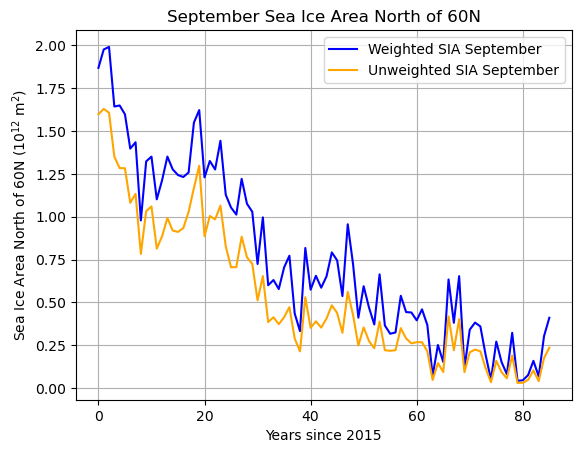

In [54]:
plt.plot(sia_sep_weighted / 1e12, label='Weighted SIA September', color='blue')
plt.plot(sia_sep_unweighted / 1e12, label='Unweighted SIA September', color='orange')
plt.xlabel('Years since 2015')
plt.ylabel('Sea Ice Area North of 60N (10$^{12}$ m$^2$)')
plt.title('September Sea Ice Area North of 60N')
plt.legend()
plt.grid()
plt.show()

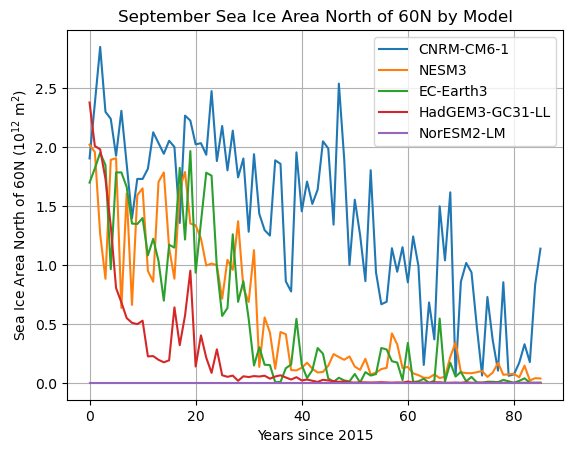

In [55]:
#plot each model's september values
for model in models:
    plt.plot(sia_sep_annual_dict[model] / 1e12, label=model)
plt.xlabel('Years since 2015')
plt.ylabel('Sea Ice Area North of 60N (10$^{12}$ m$^2$)')
plt.title('September Sea Ice Area North of 60N by Model')
plt.legend()
plt.grid()
plt.show()